In [1]:
import os, sys

recsys_cf = os.environ.get("RECSYS_STORY")
sys.path.append(recsys_cf)
os.chdir(recsys_cf)

from lib.tools import *

In [2]:
SPARK_CONFIG

{'process_label': 'RECSYS_STORY',
 'kerberos_auth': True,
 'replication_num': 1,
 'numofcores': 9,
 'numofinstances': 9}

In [3]:
SPARK_CONFIG["numofcores"] = 15

# spark 

In [4]:
sp = spark(**SPARK_CONFIG)
hive = sp.sql

# load_tables 

In [7]:
start_d = '2021-01-01'
end_d = '2021-12-01'

In [8]:
sql_query_ctl = """
SELECT DISTINCT ctl_loading
FROM {scheme}.{ctl_table}
WHERE 1=1
  AND (min_sessiondate >= '{start_date}'
       OR max_sessiondate >= '{start_date}')
  AND (min_sessiondate < '{end_date}'
       OR max_sessiondate < '{end_date}')
""".format(scheme=SBX_TEAM_DIGITCAMP,
           ctl_table=GA_VISIT_CTL_DATE_MAP,
           start_date=start_d,
           end_date=end_d)

In [9]:
ctl_loading_list = hive.sql(sql_query_ctl).toPandas()["ctl_loading"]

In [10]:
min_ctl = ctl_loading_list.min()
max_ctl = ctl_loading_list.max()

###### sbbol_clickstream 

In [16]:
visit_query = """
SELECT sbbolUserId,
       sbbolorgguid,
       hitPagePath,
       hitPageTitle,
       sessionId,
       sessionStartTime,
       sessionDate,
       hitType,
       hitTime,
       eventCategory,
       eventAction,
       eventLabel,
       hitPageHostName,
       sessionId
FROM {visit_scheme}.{visit_tb_name}
WHERE 1=1
  AND ctl_loading >= {min_ctl_loading}
  AND ctl_loading < {max_ctl_loading}
  AND sessiondate >= '{start_date}' 
  AND sessiondate < '{end_date}'
  AND hitPageHostName like 'sbi.sberbank.ru'
""".format(visit_scheme="cap_external_google_dda_external_google_analytics",
           visit_tb_name="visit",
           start_date=start_d,
           end_date=end_d,
           min_ctl_loading=min_ctl,
           max_ctl_loading=max_ctl)

In [17]:
sbbol_clickstream = hive.sql(visit_query).cache()

In [ ]:
# sbbol_clickstream.count()

In [18]:
sbbol_clickstream.dtypes

[('sbbolUserId', 'string'),
 ('sbbolorgguid', 'string'),
 ('hitPagePath', 'string'),
 ('hitPageTitle', 'string'),
 ('sessionId', 'bigint'),
 ('sessionStartTime', 'bigint'),
 ('sessionDate', 'string'),
 ('hitType', 'string'),
 ('hitTime', 'bigint'),
 ('eventCategory', 'string'),
 ('eventAction', 'string'),
 ('eventLabel', 'string'),
 ('hitPageHostName', 'string'),
 ('sessionId', 'bigint')]

###### create stats 

In [19]:
sbbol_users_visit_2021 = sbbol_clickstream.select(f.col("sbbolUserId"),
                                                  f.to_date(f.col("sessionDate")).alias("sessionDate")).distinct()

In [20]:
sbbol_users_visit_2021.cache()

DataFrame[sbbolUserId: string, sessionDate: date]

In [21]:
%%time
sbbol_users_visit_2021.count()

CPU times: user 479 ms, sys: 417 ms, total: 896 ms
Wall time: 1h 1min 41s


90652201

In [22]:
sbbol_users_visit_2021_month = sbbol_users_visit_2021.withColumn("month", f.date_trunc("month", f.col("sessionDate")))

In [ ]:
sbbol_users_visit_2021_month.show()

In [63]:
sbbol_users_visit_2021_month.select("month").distinct().show(12)

,month
0,2021-09-01
1,2021-02-01
2,2021-06-01
3,2021-08-01
4,2021-03-01
5,2021-10-01
6,2021-01-01
7,2021-05-01
8,2021-11-01
9,2021-07-01


In [24]:
sbbol_users_visit_2021_month_stat = sbbol_users_visit_2021_month.groupBy(f.col("month"), f.col("sbbolUserId"))\
                                                                .agg(f.countDistinct("sessionDate").alias("day_in_month_visit_cnt"))

In [25]:
sbbol_users_visit_2021_month_stat.cache()

DataFrame[month: timestamp, sbbolUserId: string, day_in_month_visit_cnt: bigint]

In [26]:
%%time
sbbol_users_visit_2021_month_stat.count()

CPU times: user 4.08 ms, sys: 2.57 ms, total: 6.66 ms
Wall time: 22.2 s


14407705

In [64]:
sbbol_users_visit_2021_avg_stat = sbbol_users_visit_2021_month_stat.groupBy("sbbolUserId")\
                                                                   .agg((f.sum("day_in_month_visit_cnt")/11).alias("mean_visit_month"))

###### analitycs 

###### by april 

In [29]:
april_stats_pd = sbbol_users_visit_2021_month_stat.filter(f.col("month") =="2021-04-01").toPandas()

In [41]:
april_stats_pd.head()

,month,sbbolUserId,day_in_month_visit_cnt
0,2021-04-01,3c25f095-b7f1-fc84-e054-90e2ba85d0c8,18
1,2021-04-01,dc0a1f72-13c0-4f33-b9c3-e6e33e6caa16,18
2,2021-04-01,3c25f085-e91e-fc84-e054-90e2ba85d0c8,4
3,2021-04-01,a9332b47-f891-4099-b84b-c60bb1c53428,8
4,2021-04-01,0b61233c-29fe-49e9-8b33-e1b47a0bb670,12


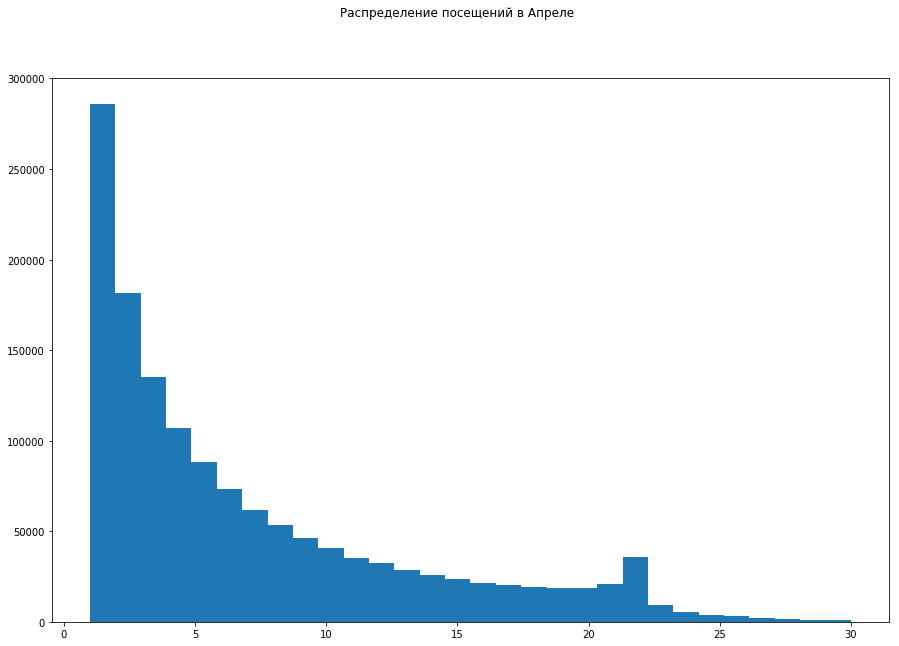

In [40]:
fig, ax = plt.subplots()
fig.suptitle('Распределение посещений в Апреле')

plt.hist(april_stats_pd["day_in_month_visit_cnt"], bins=30)

fig.set_figwidth(15)
fig.set_figheight(10)

plt.show()

###### mean_by_year 

In [65]:
sbbol_users_visit_2021_avg_stat.cache().count()

2591893

In [66]:
year_mean_stats_pd = sbbol_users_visit_2021_avg_stat.toPandas()

In [ ]:
year_mean_stats_pd.head()

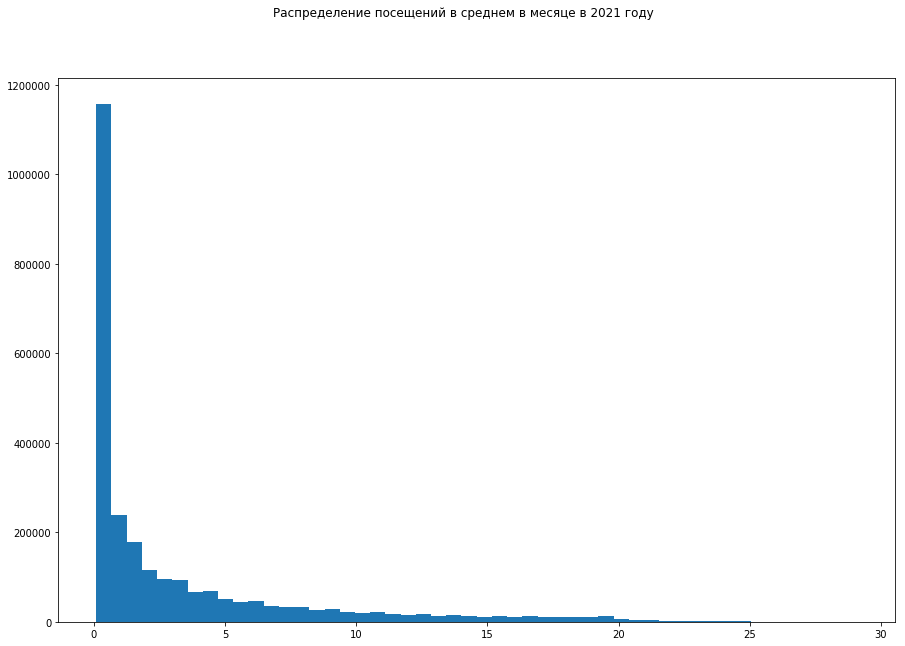

In [68]:
fig, ax = plt.subplots()
fig.suptitle('Распределение посещений в среднем в месяце в 2021 году')

plt.hist(year_mean_stats_pd["mean_visit_month"], bins=50)

fig.set_figwidth(15)
fig.set_figheight(10)

plt.show()

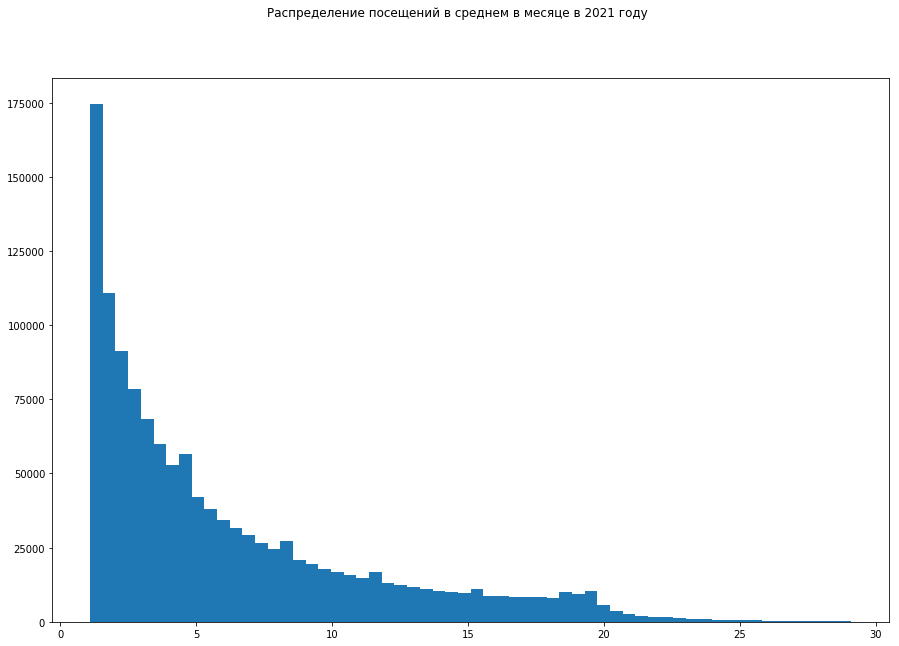

In [69]:
fig, ax = plt.subplots()
fig.suptitle('Распределение посещений в среднем в месяце в 2021 году')

plt.hist(year_mean_stats_pd[year_mean_stats_pd["mean_visit_month"] > 1]["mean_visit_month"], bins=60)

fig.set_figwidth(15)
fig.set_figheight(10)
fig.show()

Таким образом, разумно отправить в аб тест юзеров, у которых статистика посещений за год больше в среднем, чем 1 раз в месяц

In [74]:
year_mean_stats_pd[year_mean_stats_pd["mean_visit_month"] > 1].count()

sbbolUserId         1262545
mean_visit_month    1262546
dtype: int64

# visit test select 

In [83]:
ctl_load = 12548987


VISIT_SQL_QUERY = """
SELECT MAX(sessiondate) AS max_date
FROM {visit_scheme}.{visit_tb_name}
WHERE 1=1
  AND ctl_loading >= ctl_loading
""".format(visit_scheme="cap_external_google_dda_external_google_analytics",
           visit_tb_name="VISIT",
           ctl_loading=ctl_load)

In [84]:
%%time
hive.sql(VISIT_SQL_QUERY).show()

CPU times: user 61.1 ms, sys: 13 ms, total: 74.1 ms
Wall time: 5min 2s


,max_date
0,2021-11-18
